### warning: test phase, no guarantee

Generate Sample Data:

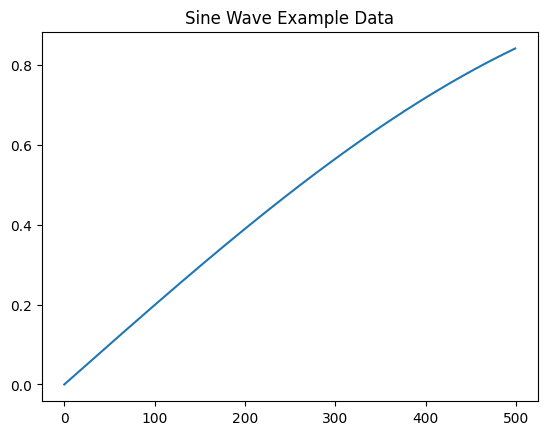

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sine wave data
t = np.arange(0, 1000, 0.1)
data = np.sin(0.02 * t)

# Plot
plt.plot(data[:500])
plt.title("Sine Wave Example Data")
plt.show()

Prepare Windowed Dataset:

In [4]:
def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = create_dataset(data, window_size)
X = np.expand_dims(X, axis=-1)  # Add feature dimension

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Transformer Block:

In [6]:
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [5]:
from tensorflow.keras import layers, models
import tensorflow as tf

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()

        # ⚙️ Multi-Head Self-Attention layer
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # 🔁 Feedforward network (like a small MLP for each position)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),  # Project back to original embedding size
        ])

        # 🧽 Normalization and regularization
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        # ⚡ Step 1: Self-Attention (this is where attention is actually applied)
        # Inputs = [Batch, Time steps, Features]
        attn_output = self.att(inputs, inputs)  # Q = K = V = inputs → self-attention

        # Add & Normalize (residual connection + normalization)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # 🧠 Step 2: Feedforward transformation
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        # Add & Normalize again
        return self.layernorm2(out1 + ffn_output)

ModuleNotFoundError: No module named 'tensorflow'

Full Model with Transformer Block:

In [ ]:
def build_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)  # Input shape: (window_size, 1)

    # 🔡 Initial projection to higher dimension
    x = layers.Dense(64)(inputs)

    # 🔁 Transformer block — includes attention and feedforward layers
    x = TransformerBlock(embed_dim=64, num_heads=2, ff_dim=128)(x)

    # 📉 Collapse across time dimension
    x = layers.GlobalAveragePooling1D()(x)

    # 🔄 Final prediction layers
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(1)(x)  # Final prediction: a single value

    return models.Model(inputs=inputs, outputs=x)